In [76]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve


In [77]:
data = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")


In [78]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [79]:
data_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

поле education имеет пропуски

In [80]:
data["education"].isnull().sum(), data_test["education"].isnull().sum()


(307, 171)

In [81]:
data["education"].isnull().sum()/len(data)*100, \
data_test["education"].isnull().sum()/len(data)*100


(0.41599479667746175, 0.2317104567812572)

4% и 2% соответственно 

## EDA + PREPROCESSING

проведем ускоренный предварительный анализ данных с помощью pandas_profiling, сохранив результат в формате html

In [82]:
from pandas_profiling import ProfileReport


In [83]:
profile = data.profile_report()
profile_test = data_test.profile_report()


In [84]:
profile.to_widgets()


Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [85]:
profile_test.to_widgets()


Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# сохраним
profile.to_file("pred_analysis.html")
profile_test.to_file("pred_analysis_test.html")


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

На основе предварительного анализа отметим следующие важные моменты
1. Пропуски встречаются только в поле education
2. Числовые признаки "age", "decline_app_cnt","bki_request_cnt", "income" имеют распределение с длинным правым хвостом
3. Бинарные признаки "car", "car_type" можно заменить одним категориальным
4. Существует корреляция признаков "home_address" и "work_address"

******************

In [86]:
# прочитаем данные:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

# объединяем трейн и тест в один датасет:
data_train['train_flag'] = 1 # помечаем где у нас трейн
data_test['train_flag'] = 0 # помечаем где у нас тест
data_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, поэтому пока просто заполняем нулями

data = data_test.append(data_train, sort=False).reset_index(drop=True) # объединяем

## 0. client_id
не несет никакой смысловой нагрузки, кроме идентификации, удалим

In [87]:
data = data.drop(["client_id"], axis = 1)

## 1. app_date
преобразуем дату в количество дней,  прошедших от даты подачи заявки до условной даты "сеггодня", которую определим как дату последней заявки (data_app_date_max)
- добавим новый признак "days_passed"
- удалим "app_date"

In [88]:
# преобразуем даты в числовой признак:
data["app_date"] = pd.to_datetime(data["app_date"])
data_app_date_max = data.app_date.max()
data_app_date_max


Timestamp('2014-04-30 00:00:00')

## NEW FEATURE: "days_passed"

In [89]:
data["days_passed"] = (data_app_date_max - data["app_date"]).dt.days + 1


распределение нового признака "days_passed" выглядит так:
    

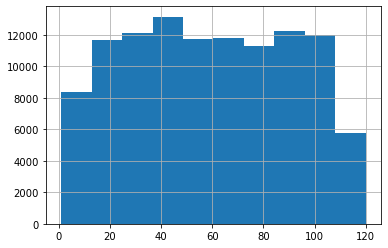

In [90]:
data["days_passed"].hist()


In [91]:
data = data.drop(["app_date"], axis = 1)

## 2. education
заменим пропуски на "WOE"
перекодируем признак с помощью OrdinalEncoder

In [92]:
data.fillna("WOE", inplace=True)


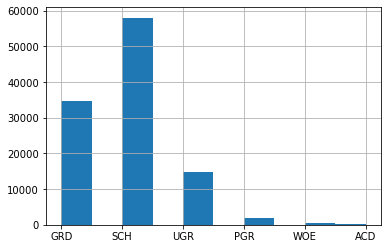

In [93]:
data["education"].hist()

In [94]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_enc = OrdinalEncoder(categories=[['WOE', 'SCH', 'GRD', 'UGR', 'PGR', 'ACD'],])
data[['education']] = ordinal_enc.fit_transform(data[['education']])


In [95]:
data["education"].value_counts()


1.0    57998
2.0    34768
3.0    14748
4.0     1865
0.0      478
5.0      291
Name: education, dtype: int64

## 3. sex
бинарный признак, обработаем его ниже одновременно с другими бинарными признаками с помощью LabelEncoder()

## 4. age 
длинный правый хвост, логарифмируем признак вместе с другими числовыми признаками, имеющими такое же распределение

## 5. "car" 
бинарный признак - удалим после трансформации


## 6. "car_type"
бинарный признак - удалим после трансформации


## 7. decline_app_cnt
 

прологарифмируем одновременно с другими числовыми признаками, имеющими длинный правый хвост распределения

## 8. good_work 


бинарный признак, обработаем вместе с бинарными

## 9.   score_bki        
 

оставляем как есть

## 10.  bki_request_cnt
 

логарифмируем 

## 11.  region_rating 


оставляем как есть

## 12.  home_address 
 

оставляем без изменений

## 13.  work_address
оставим


## 14.  income 
логарифмируем

## 15. sna
 

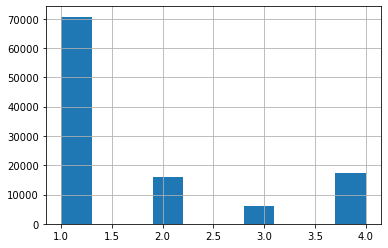

In [96]:
data["sna"].hist()

## 16.  first_time
 

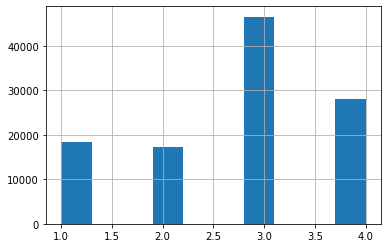

In [97]:
data["first_time"].hist()

## 17.  foreign_passport  
обработаем с бинарными признаками

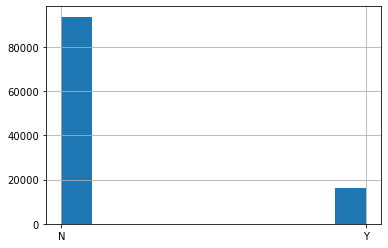

In [98]:
data["foreign_passport"].hist()

## 18. train_flag
используем для разделения датасетов

## 19. default
целевая переменная

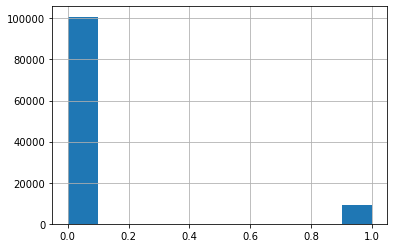

In [99]:
data["default"].hist()

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  float64
 1   sex               110148 non-null  object 
 2   age               110148 non-null  int64  
 3   car               110148 non-null  object 
 4   car_type          110148 non-null  object 
 5   decline_app_cnt   110148 non-null  int64  
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  int64  
 9   region_rating     110148 non-null  int64  
 10  home_address      110148 non-null  int64  
 11  work_address      110148 non-null  int64  
 12  income            110148 non-null  int64  
 13  sna               110148 non-null  int64  
 14  first_time        110148 non-null  int64  
 15  foreign_passport  110148 non-null  object 
 16  train_flag        11

распределим признаки по типам

In [101]:
# binary
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport" ] 

# categorical
cat_cols = ["education", "home_address", "work_address", \
            "sna", "first_time", "car_cat"]
# numeric
num_cols = ["age", "decline_app_cnt", "score_bki", \
            "bki_request_cnt", "region_rating", "income", "days_passed"]


## БИНАРНЫЕ ПРИЗНАКИ:

In [102]:
# binary
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport" ] 


In [103]:
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    data_test[column] = label_encoder.fit_transform(data_test[column])
    print(column, dict(enumerate(label_encoder.classes_)))


sex {0: 'F', 1: 'M'}
car {0: 'N', 1: 'Y'}
car_type {0: 'N', 1: 'Y'}
good_work {0: 0, 1: 1}
foreign_passport {0: 'N', 1: 'Y'}


## ЧИСЛОВЫЕ ПРИЗНАКИ 
логарифмируем "age", "decline_app_cnt","bki_request_cnt", "income"

In [104]:
# numeric
num_cols = ["age", "decline_app_cnt", "score_bki", \
            "bki_request_cnt", "region_rating", "income", "days_passed"]

# to logarithm
num_cols_log = ["age", "decline_app_cnt", "bki_request_cnt", "income"]


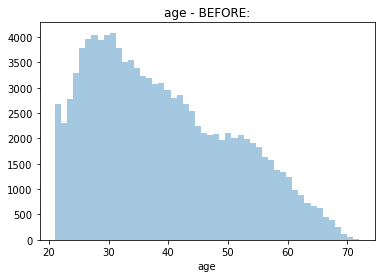

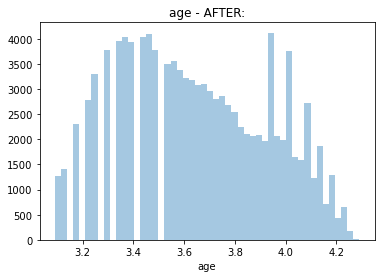

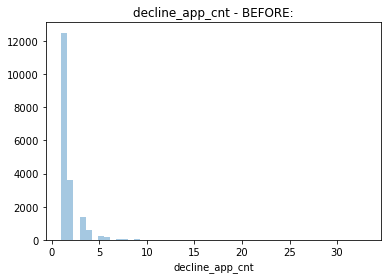

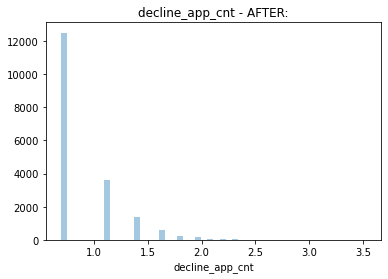

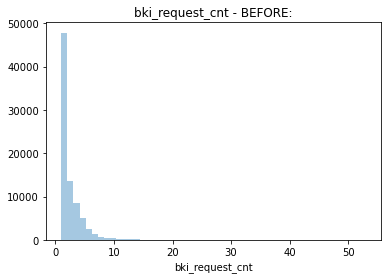

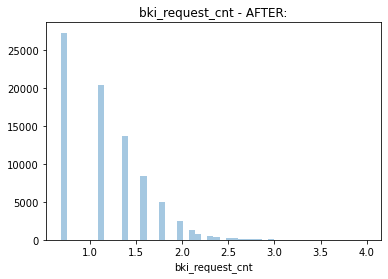

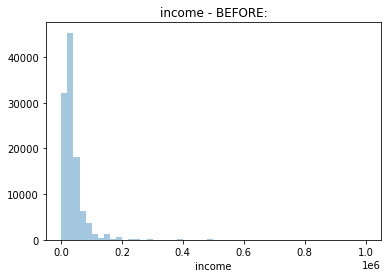

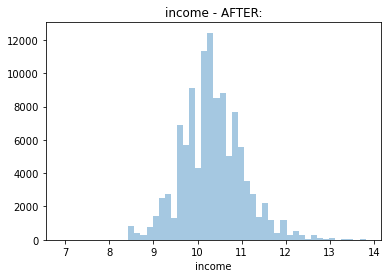

In [105]:
for i in num_cols_log:
    
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i+" - BEFORE:")
    plt.show()
    data[i] = np.log(data[i] + 1)
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i+" - AFTER:")
    plt.show()
    

### Оценка корреляций

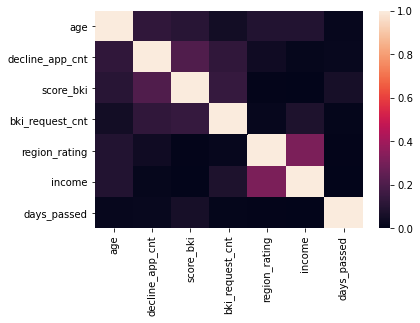

In [106]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)


In [107]:
data[num_cols].corr().abs()


,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income,days_passed
age,1.000000,0.128624,0.109169,0.050241,0.090629,0.090734,0.017643
decline_app_cnt,0.128624,1.000000,0.207342,0.127531,0.042188,0.013959,0.022499
score_bki,0.109169,0.207342,1.000000,0.141600,0.007132,0.002592,0.061969
bki_request_cnt,0.050241,0.127531,0.141600,1.000000,0.015935,0.078649,0.008747
region_rating,0.090629,0.042188,0.007132,0.015935,1.000000,0.313187,0.004645
income,0.090734,0.013959,0.002592,0.078649,0.313187,1.000000,0.002498
days_passed,0.017643,0.022499,0.061969,0.008747,0.004645,0.002498,1.000000


признаки не скореллированы, за исключением region_rating и income (0.313186)

### Значимость  числовых переменных

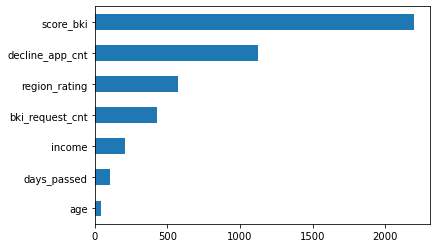

In [108]:
imp_num = pd.Series(f_classif(data[num_cols],
                    data['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')


Самые важные признаки:
- score_bki
- decline_app_cnt

Самый малозначимый:
- age

## КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ

## NEW FEATURE: "car_cat"

In [111]:
# создаем
data["car_cat"] = data["car"] + data["car_type"]
# удаляем:
data.drop(["car", "car_type"], axis=1, inplace=True)


In [112]:
# categorical
cat_cols = ["education", "home_address", "work_address",
            "sna", "first_time", "car_cat"]


In [113]:
# убедимся, что категориальные признаки являются числами
for col in cat_cols:
    print (data[col].unique())


[2. 1. 3. 4. 0. 5.]
[1 2 3]
[2 3 1]
[1 4 2 3]
[4 3 1 2]
[2 0 1]


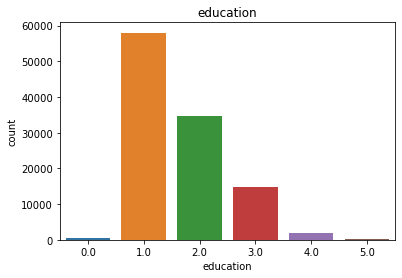

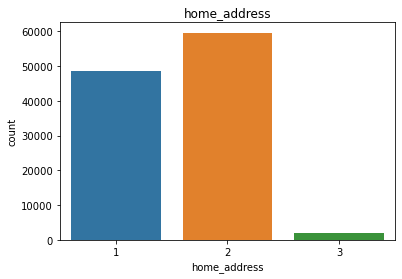

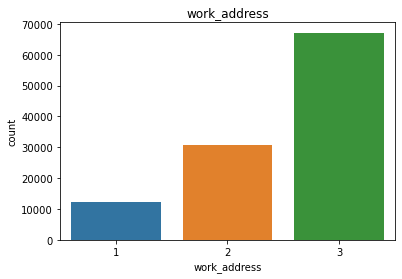

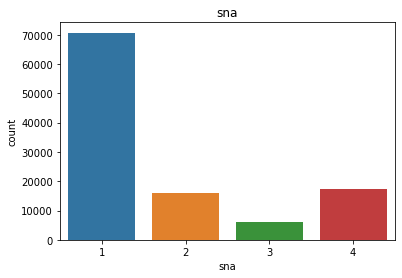

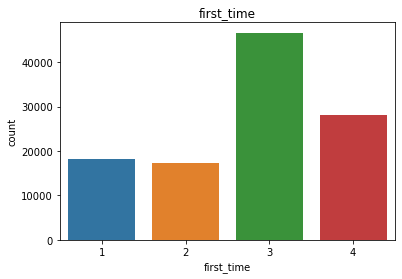

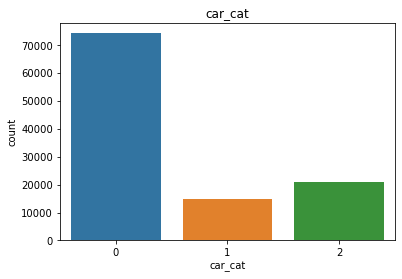

In [28]:
for column in cat_cols:
    plt.figure()
    sns.countplot(data[column])
    plt.title(column)
    plt.show()


### Значимость категориальных и бинарных признаков

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.



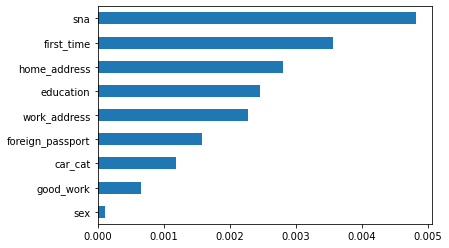

In [114]:
# categorical
cat_cols = ["education", "home_address", "work_address",
            "sna", "first_time", "car_cat"]
# binary
bin_cols = ["sex", "good_work", "foreign_passport"]

imp_cat = Series(mutual_info_classif(
    data[bin_cols + cat_cols], data['default'], discrete_features=True),
    index=bin_cols+cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')


## Подготовка данных к машинному обучению

In [31]:
# Теперь выделим тестовую часть
data_train = data.query('train_flag == 1').drop(['train_flag'], axis=1)
data_test = data.query('train_flag == 0').drop(['train_flag'], axis=1)


In [34]:
y = data_train["default"].values       # наш таргет
X = data_train.drop(["default"], axis=1)
     

для категориальных признаков добавим новые колонки для обоих датасетов:

In [35]:
train_cat = OneHotEncoder(sparse=False).fit_transform(
    data_train[cat_cols].values)
test_cat = OneHotEncoder(sparse=False).fit_transform(
    data_test[cat_cols].values)


In [38]:
# Стандартизация числовых переменных
train_num = StandardScaler().fit_transform(data_train[num_cols].values)
test_num = StandardScaler().fit_transform(data_test[num_cols].values)


In [54]:
# Объединяем

X = np.hstack([train_num, data_train[bin_cols].values, train_cat])
y = data_train["default"].values

X_test = np.hstack([test_num, data_test[bin_cols].values, test_cat])


## Подготовка признаков для модели завершена. 

In [47]:
# Разделим данные для обучения следующим образом:

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=42)


Обучим модель на стандартных настройках логистической регрессии:

In [48]:
model1 = LogisticRegression(
    random_state=42, solver='liblinear').fit(X_train, y_train)


##  Оценка качества модели

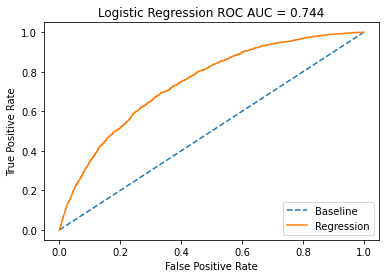

In [49]:
probs = model1.predict_proba(X_valid)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()


Первое значение метрики при 0.677, то есть удалось немного ее улучшить

## РЕГУЛЯРИЗАЦИЯ

In [50]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

# model = LogisticRegression()
# model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model1, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])


Лучшее Penalty: l1
Лучшее C: 21.544346900318832


In [52]:
model2 = LogisticRegression(penalty="l1",
                            C=21.544346900318832,
                            fit_intercept=True,
                            intercept_scaling=1,
                            class_weight="balanced",
                            solver="liblinear",
                            max_iter=2000,
                            multi_class="auto")
model2.fit(X_train, y_train)


LogisticRegression(C=21.544346900318832, class_weight='balanced', max_iter=2000,
                   penalty='l1', solver='liblinear')

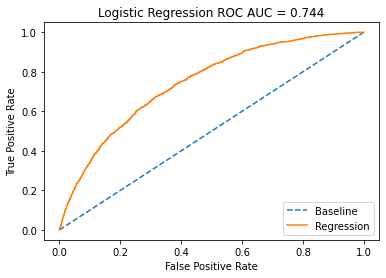

In [55]:
y_pred = model2.predict(X_valid)
y_pred_prob = model2.predict_proba(X_valid)[:, 1]

y_pred_test = model2.predict(X_test)
y_pred_prob_test = model2.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob)
roc_auc = roc_auc_score(y_valid, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [56]:
# новая модель на всех данных
model3 = LogisticRegression(penalty="l1",
                            C=21.544346900318832,
                            fit_intercept=True,
                            intercept_scaling=1,
                            class_weight="balanced",
                            solver="liblinear",
                            max_iter=2000,
                            multi_class="auto")
model3.fit(X, y)


LogisticRegression(C=21.544346900318832, class_weight='balanced', max_iter=2000,
                   penalty='l1', solver='liblinear')

In [59]:
y_pred_test = model3.predict(X_test)
y_pred_prob_test = model3.predict_proba(X_test)[:, 1]


In [60]:
y_pred_prob_test


array([0.20630757, 0.80404628, 0.3102911 , ..., 0.78978761, 0.64688966,
       0.71129452])

In [71]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


считаем "client_id" еще раз

In [115]:
client_id = pd.read_csv("test.csv")["client_id"]


In [75]:
submission = pd.DataFrame({'client_id': client_id, "default": y_pred_prob_test})
submission.to_csv('submission.csv', index=False)
submission.head()


,client_id,default
0,74835,0.206308
1,17527,0.804046
2,75683,0.310291
3,26883,0.414762
4,28862,0.145758
